In [79]:
setwd("/home/pasoneto/Documents/github/doc_suomi/code")
source("utils.R")
source("data_cook.R")
library(randomForest)
library("splines")
setwd("/home/pasoneto/Documents/github/doc_suomi/data")

#### data prep
oi = fread("interpolated/nn_interpol.csv")
colnames(oi) = c("index", "valence", "energy", "loudness", "tempo", "album_id", "track_number")

dt = oi %>% group_by(album_id) %>%
            dplyr::select(album_id, valence, energy, loudness, tempo, track_number) %>%
            mutate(position = segment(track_number)) %>%
            group_by(album_id, position) %>% ungroup() %>% group_by(album_id) %>%
            mutate(track_number = seq(1, NROW(track_number), 1), 
                   position = as.factor(position)) %>%
            mutate(valence = minmax(valence), energy = minmax(energy), 
                   loudness = minmax(loudness), tempo = minmax(tempo), 
                   track_number = minmax(track_number)) %>% ungroup() %>% group_by(album_id) %>%
            mutate(valence_next = shift(valence, -1), energy_next = shift(energy, -1), loudness_next = shift(loudness, -1), tempo_next = shift(tempo, -1)) %>%
            ungroup() %>% na.omit() %>%
            mutate(position = as.factor(position)) %>%
            fastDummies::dummy_cols(select_columns = "position", remove_selected_columns = TRUE)

#Train test split
treino = treino_teste(dt)$train
teste = treino_teste(dt)$test

treino = apply(as.matrix(treino), 2, as.numeric)
teste = apply(as.matrix(teste), 2, as.numeric)

In [80]:
#model's hyperparameters
model_setup = function(){
        library("keras")
     model <- keras_model_sequential() %>% 
        layer_dense(units = 16,
              activation = "relu",
              input_shape = c(8)) %>% 
        layer_dropout(0.2) %>% 
        layer_dense(units = 25,
              activation = "relu") %>% 
        layer_dropout(0.2) %>% 
        layer_dense(units = 25,
              activation = "relu") %>% 
        layer_dropout(0.2) %>% 
        layer_dense(units = 1)

     model %<>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop(),
                  metrics = c("mean_absolute_error"))
    return(model)
}

# Function receives data and returns fitted model
lstm = function(var_interest, var_pred, model){
        y.treino = as.matrix(treino[, var_interest])
        x.treino = as.matrix(treino[, var_pred])
        y.teste = as.matrix(teste[, var_interest])
        x.teste = as.matrix(teste[, var_pred])
    
    model %>% 
      fit(x.treino,
          y.treino,
          epoch = 100,
          batch_size = 16,
          validation_split = 0.1,
          callbacks = c(callback_early_stopping(monitor = "val_mean_absolute_error",
                                                patience = 5)),
          verbose = 2)
    return(model)
}

model_eval = function(model_fitted, x.teste, y.teste){
    pre = predict(model_fitted, x.teste)
    return(Metrics::rmse(pre, y.teste))    
}

#Calling function
model = model_setup()
valence = lstm(var_interest = "valence_next", 
               var_pred = c("valence", "energy", "loudness", "tempo", "track_number", "position_1st", "position_2nd", "position_3d"),
               model = model)
pred_vars = c("valence", "energy", "loudness", "tempo", "track_number", "position_1st", "position_2nd", "position_3d")

model_eval(model_fitted = valence,   
           x.teste = teste[, pred_vars], 
           y.teste = teste[, c("valence_next")])

[1] 0.3147793

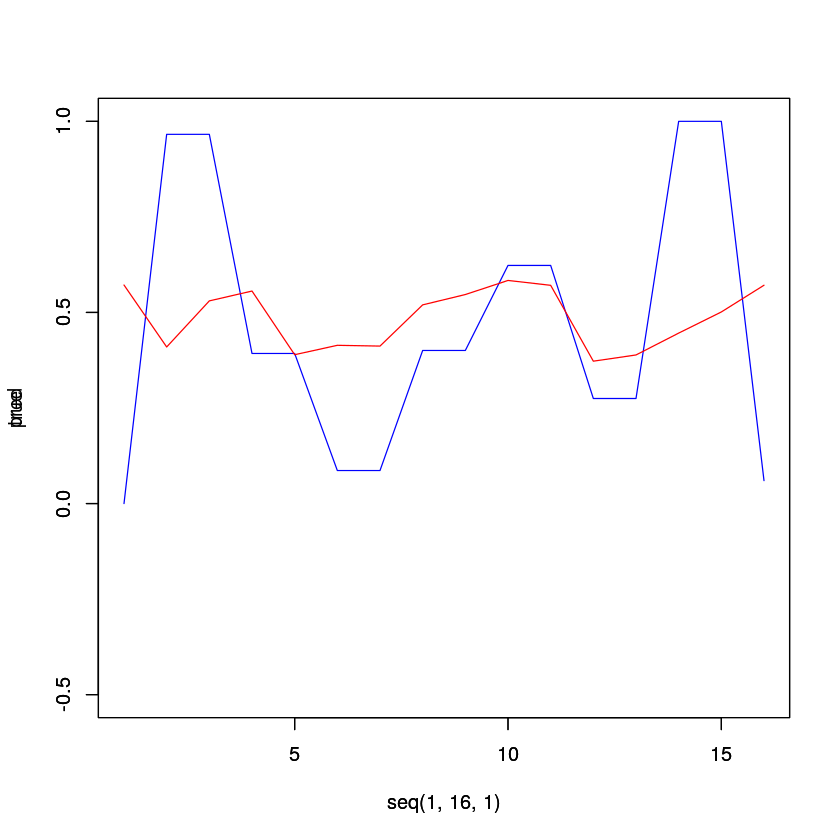

In [82]:

pred = predict(valence, teste[, pred_vars][16:31, ])
true = teste[, "valence_next"][1:16]

plot(seq(1, 16, 1), true, col = 'blue', type="l", ylim = c(-0.5, 1))
par(new = TRUE)
plot(seq(1, 16, 1), pred, col = 'red',  type="l", ylim = c(-0.5, 1))